In [5]:
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import seaborn as sns 
color = sns.color_palette() 
import matplotlib as mpl 
%matplotlib inline 
from sklearn import preprocessing as pp
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import precision_recall_curve, average_precision_score, log_loss 
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import (RandomForestClassifier,
                              AdaBoostClassifier,
                              GradientBoostingClassifier,
                              HistGradientBoostingClassifier)
from nltk.corpus import stopwords
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb 
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer 
import keras
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit, GridSearchCV
from keras.models import Sequential
from keras.layers import Embedding, GlobalMaxPool1D
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM

In [6]:
df=pd.read_csv(r"E:\Projects\fake job detection\data\fake_job_postings.csv") 
df

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


In [7]:
print(df.shape)
print(df["fraudulent"].value_counts())

(17880, 18)
0    17014
1      866
Name: fraudulent, dtype: int64


In [8]:
df = df.replace(np.nan, '', regex=True)
def standardize_text(df, text_field):
    df2 = df.copy(deep=True)
    df2[text_field] = df[text_field].str.replace(r"http\S+", "", regex=True)
    df2[text_field] = df[text_field].str.replace(r"http", "", regex=True)
    df2[text_field] = df[text_field].str.replace(r"@\S+", "", regex=True)
    df2[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ", regex=True)
    df2[text_field] = df[text_field].str.replace(r"@", "at", regex=True)
    df2[text_field] = df[text_field].str.lower()
    return df2
df_clean = standardize_text(df, "description")

In [9]:
df_clean['text'] = df_clean[['title', 'department','company_profile','description','requirements',
                     'benefits']].apply(lambda x: ' '.join(x), axis = 1)

In [10]:
tokenizer = RegexpTokenizer(r'\w+')
df_clean["tokens"] = df_clean["text"].apply(tokenizer.tokenize)
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
lemmatizer = WordNetLemmatizer()
studentDfObj = df_clean["tokens"]
listOfDFRows = studentDfObj.to_numpy().tolist()
len(listOfDFRows)

17880

In [12]:
lemm_tokens = []
lemms = []
for i in range(len(listOfDFRows)):
    for words in listOfDFRows[i]:
        if words not in stopwords.words('english'):
            lemmas = lemmatizer.lemmatize(words.lower(), pos='v')
            lemms.append(lemmas)
    lemm_tokens.append(lemms)
    lemms = []
a = lemm_tokens
%store a

Stored 'a' (list)


In [13]:
%store -r a
len(a)

17880

In [14]:
df_clean = df_clean.assign(lemm_tokens=a)

In [15]:
y = df_clean['fraudulent']
X = df_clean['lemm_tokens']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

## Balanced vs. Unbalanced data

Use TFIdfVectorizer on dataframe

In [16]:
def dummy_fun(doc):
    return doc
tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(14304, 87972)
(3576, 87972)


NearMiss for Balancing Data

In [17]:
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0)))
from imblearn.under_sampling import NearMiss
nr = NearMiss()

X_train_miss, y_train_miss = nr.fit_resample(X_train_tfidf, y_train.ravel())
X_test_miss, y_test_miss = nr.fit_resample(X_test_tfidf, y_test.ravel())

print('After Undersampling, the shape of train_X: {}'.format(X_train_miss.shape))
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape))
print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1)))
print("After Undersampling, counts of label '0': {}".format(sum(y_train_miss == 0)))

Before Undersampling, counts of label '1': 678
Before Undersampling, counts of label '0': 13626 

After Undersampling, the shape of train_X: (1356, 87972)
After Undersampling, the shape of train_y: (1356,) 

After Undersampling, counts of label '1': 678
After Undersampling, counts of label '0': 678


In [18]:
sgd_clf = SGDClassifier(loss="hinge", penalty="l2", random_state=100, max_iter=1000)
sgd_clf.fit(X_train_miss, y_train_miss)
y_predicted_sgd_clf = sgd_clf.predict(X_test_miss)
print(classification_report(y_test_miss, y_predicted_sgd_clf))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       188
           1       0.92      0.91      0.92       188

    accuracy                           0.92       376
   macro avg       0.92      0.92      0.92       376
weighted avg       0.92      0.92      0.92       376



In [19]:
print("ROC-AUC:", roc_auc_score(y_predicted_sgd_clf,y_test_miss))
print("Accuracy:", accuracy_score(y_predicted_sgd_clf,y_test_miss))

ROC-AUC: 0.9175650058003
Accuracy: 0.9175531914893617


In [20]:
clf_log = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_log.fit(X_train_miss, y_train_miss)
y_predicted_log = clf_log.predict(X_test_miss)

print(classification_report(y_test_miss, y_predicted_log))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       188
           1       0.92      0.91      0.92       188

    accuracy                           0.92       376
   macro avg       0.92      0.92      0.92       376
weighted avg       0.92      0.92      0.92       376



In [21]:
print("ROC-AUC:", roc_auc_score(y_predicted_log,y_test_miss))
print("Accuracy:", accuracy_score(y_predicted_log,y_test_miss))

ROC-AUC: 0.917659544361115
Accuracy: 0.9175531914893617


Use Word Embeddings on dataframe

In [22]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=14727)
tokenizer.fit_on_texts(X)
train_wordemb = tokenizer.texts_to_sequences(X_train)
test_wordemb = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [23]:
from keras.preprocessing.sequence import pad_sequences
maxlen = 100

train_wordemb = pad_sequences(train_wordemb, padding='post', maxlen=maxlen)
test_wordemb = pad_sequences(test_wordemb, padding='post', maxlen=maxlen)

In [24]:
X_train_miss2, y_train_miss2 = nr.fit_resample(train_wordemb, y_train.ravel())
X_test_miss2, y_test_miss2 = nr.fit_resample(test_wordemb, y_test.ravel())

In [25]:
from keras.models import Sequential
from keras import layers

embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim = vocab_size,
                           output_dim=embedding_dim, 
                           input_length=100))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           4967700   
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                50010     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 5,017,721
Trainable params: 5,017,721
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.9069


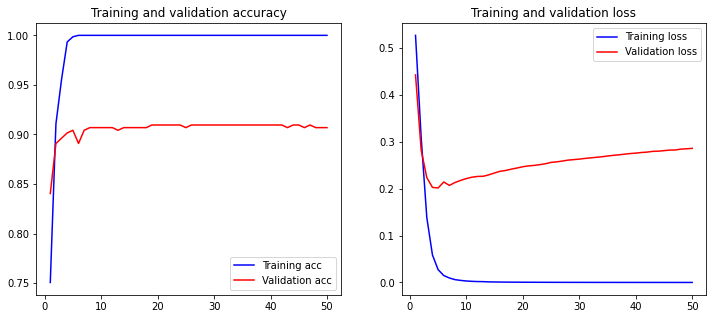

In [26]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
history = model.fit(X_train_miss2, y_train_miss2, epochs=50, verbose=False,
                    validation_data=(X_test_miss2, y_test_miss2), batch_size=50)
loss, accuracy = model.evaluate(X_train_miss2, y_train_miss2, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_miss2, y_test_miss2, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [27]:
model1 = Sequential()
model1.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model1.add(layers.GlobalMaxPool1D())
model1.add(layers.Dense(10, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           4967700   
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 4,968,221
Trainable params: 4,968,221
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 0.9971
Testing Accuracy:  0.9096


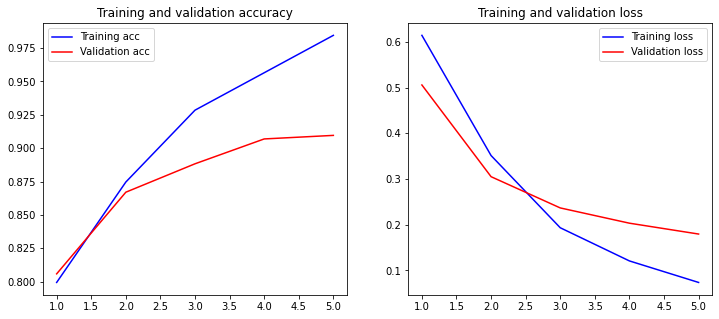

In [28]:
history1 = model1.fit(X_train_miss2, y_train_miss2, epochs=5, verbose=False,
                    validation_data=(X_test_miss2, y_test_miss2), batch_size=10)
loss, accuracy = model1.evaluate(X_train_miss2, y_train_miss2, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model1.evaluate(X_test_miss2, y_test_miss2, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history1)

Found, that the method TFIdfVectorizer gives better results than Tokenizer

# use a TFIdfVectorizer method with unbalanced data

In [29]:
sgd_clf2 = SGDClassifier(loss="hinge", penalty="l2", random_state=100, max_iter=1000)
sgd_clf2.fit(X_train_tfidf, y_train)
y_predicted_sgd_clf2 = sgd_clf2.predict(X_test_tfidf)
print(classification_report(y_test, y_predicted_sgd_clf2))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3388
           1       1.00      0.57      0.73       188

    accuracy                           0.98      3576
   macro avg       0.99      0.79      0.86      3576
weighted avg       0.98      0.98      0.97      3576



In [30]:
print("ROC-AUC:", roc_auc_score(y_predicted_sgd_clf2,y_test))
print("Accuracy:", accuracy_score(y_predicted_sgd_clf2,y_test))

ROC-AUC: 0.9884659746251442
Accuracy: 0.9776286353467561


In [31]:
clf_log2 = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', random_state=40)
clf_log2.fit(X_train_tfidf, y_train)
y_predicted_log2 = clf_log2.predict(X_test_tfidf)

print(classification_report(y_test, y_predicted_log2))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3388
           1       0.92      0.78      0.85       188

    accuracy                           0.99      3576
   macro avg       0.96      0.89      0.92      3576
weighted avg       0.98      0.99      0.98      3576



In [32]:
print("ROC-AUC:", roc_auc_score(y_predicted_log2,y_test))
print("Accuracy:", accuracy_score(y_predicted_log2,y_test))

ROC-AUC: 0.9562647362521465
Accuracy: 0.985178970917226


The greatest accuracy and ROC-AUC metrics was in the model SGDClassifier (98% ROC-AUC, 98% accuracy)